In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import random
from scipy.spatial.distance import cdist
import pickle
import os
from tqdm import tqdm
from skimage import feature, measure, filters, segmentation
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

In [2]:
class DaVinki:
    def __init__(self, target_image_path, tile_size=32, grid_size=(64, 64)):
        self.target_image_path = target_image_path
        self.tile_size = tile_size
        self.grid_size = grid_size
        
        self.target_image = None
        self.target_tiles = []
        self.cifar_images = []
        self.cifar_features = []
        self.target_features = []
        
    def load_cifar_dataset(self, num_samples=10000):
        print("Loading CIFAR-10 dataset...")
        
        total_tiles = self.grid_size[0] * self.grid_size[1]
        required_samples = max(num_samples, total_tiles * 2)  
        
        try:
            cifar = fetch_openml('CIFAR_10', version=1, return_X_y=True, as_frame=False)
            X, y = cifar
            X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
            
            unique_classes = np.unique(y)
            samples_per_class = required_samples // len(unique_classes)
            
            selected_indices = []
            for class_label in unique_classes:
                class_indices = np.where(y == class_label)[0]
                selected = np.random.choice(class_indices, 
                                          min(samples_per_class, len(class_indices)), 
                                          replace=False)
                selected_indices.extend(selected)
            
            if len(selected_indices) < required_samples:
                remaining_indices = list(set(range(len(X))) - set(selected_indices))
                additional_needed = required_samples - len(selected_indices)
                additional_selected = np.random.choice(remaining_indices, 
                                                     min(additional_needed, len(remaining_indices)), 
                                                     replace=False)
                selected_indices.extend(additional_selected)
            
            self.cifar_images = X[selected_indices[:required_samples]]
            self.cifar_labels = y[selected_indices[:required_samples]]
            
        except Exception as e:
            print(f"Error loading CIFAR-10: {e}")
            self.cifar_images = self.generate_synthetic_images(required_samples)
            self.cifar_labels = np.random.randint(0, 10, required_samples)
        
        print(f"Loaded {len(self.cifar_images)} CIFAR images (Required: {total_tiles} unique tiles)")
        
    def generate_synthetic_images(self, num_samples):
        images = []
        patterns = ['gradient', 'stripes', 'circles', 'checker', 'noise', 'blend', 'waves', 'spiral']
        
        for i in range(num_samples):
            pattern = patterns[i % len(patterns)]
            img = np.zeros((32, 32, 3), dtype=np.uint8)
            
            color1 = np.random.randint(0, 256, 3)
            color2 = np.random.randint(0, 256, 3)
            color3 = np.random.randint(0, 256, 3)
            
            variation = i // len(patterns)
            
            if pattern == 'gradient':
                direction = variation % 4 
                for y in range(32):
                    for x in range(32):
                        if direction == 0:  
                            ratio = x / 32
                        elif direction == 1: 
                            ratio = y / 32
                        elif direction == 2:  
                            ratio = (x + y) / 64
                        else:  
                            ratio = np.sqrt((x-16)**2 + (y-16)**2) / 22
                        ratio = min(ratio, 1.0)
                        img[y, x] = color1 * (1 - ratio) + color2 * ratio
                        
            elif pattern == 'stripes':
                stripe_width = 2 + (variation % 6) 
                direction = (variation // 6) % 2 
                for pos in range(0, 32, stripe_width * 2):
                    if direction == 0:  
                        img[pos:pos+stripe_width, :] = color1
                        img[pos+stripe_width:pos+stripe_width*2, :] = color2
                    else:  
                        img[:, pos:pos+stripe_width] = color1
                        img[:, pos+stripe_width:pos+stripe_width*2] = color2
                        
            elif pattern == 'circles':
                num_circles = 1 + (variation % 3)  
                for circle_idx in range(num_circles):
                    center_x = 8 + (circle_idx * 8) % 16
                    center_y = 8 + (circle_idx * 8) % 16
                    radius = 4 + (variation % 8)
                    for x in range(32):
                        for y in range(32):
                            dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                            if dist < radius:
                                img[x, y] = [color1, color2, color3][circle_idx % 3]
                                
            elif pattern == 'checker':
                check_size = 2 + (variation % 6)
                for x in range(0, 32, check_size):
                    for y in range(0, 32, check_size):
                        color = color1 if ((x//check_size) + (y//check_size)) % 2 == 0 else color2
                        img[x:x+check_size, y:y+check_size] = color
                        
            elif pattern == 'noise':
                base_color = color1
                noise_level = 20 + (variation % 50)
                noise = np.random.normal(0, noise_level, (32, 32, 3))
                img = np.clip(base_color + noise, 0, 255).astype(np.uint8)
                
            elif pattern == 'blend':
                x_grad = np.linspace(0, 1, 32)
                y_grad = np.linspace(0, 1, 32)
                X, Y = np.meshgrid(x_grad, y_grad)
                
                blend_type = variation % 3
                if blend_type == 0:
                    img[:, :, 0] = color1[0] * (1 - X) + color2[0] * X
                    img[:, :, 1] = color1[1] * (1 - Y) + color2[1] * Y
                    img[:, :, 2] = color1[2] * (X * Y) + color3[2] * (1 - X * Y)
                elif blend_type == 1:
                    img[:, :, 0] = color1[0] * np.sin(X * np.pi) + color2[0] * np.cos(Y * np.pi)
                    img[:, :, 1] = color1[1] * X + color2[1] * Y
                    img[:, :, 2] = color3[2] * (X + Y) / 2
                else:
                    img[:, :, 0] = color1[0] * (X * Y) + color2[0] * (1 - X * Y)
                    img[:, :, 1] = color1[1] * np.abs(X - Y) + color2[1] * (1 - np.abs(X - Y))
                    img[:, :, 2] = color3[2]
                    
                img = np.clip(img, 0, 255).astype(np.uint8)
                
            elif pattern == 'waves':
                frequency = 1 + (variation % 4)
                for x in range(32):
                    for y in range(32):
                        wave_val = np.sin(x * frequency * np.pi / 16) * np.cos(y * frequency * np.pi / 16)
                        intensity = (wave_val + 1) / 2
                        img[y, x] = color1 * intensity + color2 * (1 - intensity)
                        
            elif pattern == 'spiral':
                center = (16, 16)
                for x in range(32):
                    for y in range(32):
                        dx, dy = x - center[0], y - center[1]
                        angle = np.arctan2(dy, dx)
                        radius = np.sqrt(dx**2 + dy**2)
                        spiral_val = (angle + radius * 0.2 + variation) % (2 * np.pi)
                        intensity = spiral_val / (2 * np.pi)
                        img[y, x] = color1 * intensity + color2 * (1 - intensity)
            
            images.append(img)
        
        return np.array(images)
        
    def load_target_image(self):
        print("Loading target image...")
        
        if not os.path.exists(self.target_image_path):
            print("Creating sample target image...")
            self.target_image = self.create_artistic_target()
        else:
            img = cv2.imread(self.target_image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            target_size = (self.grid_size[1] * self.tile_size, 
                          self.grid_size[0] * self.tile_size)
            self.target_image = cv2.resize(img, target_size)
        
        print(f"Target image shape: {self.target_image.shape}")
        
    def create_artistic_target(self):
        height = self.grid_size[0] * self.tile_size
        width = self.grid_size[1] * self.tile_size
        
        img = np.zeros((height, width, 3), dtype=np.uint8)
        
        for y in range(height):
            for x in range(width):
                r = 100 + 155 * (y / height) * (1 - x / width)
                g = 50 + 100 * (x / width) + 50 * (y / height)
                b = 150 + 105 * (1 - y / height) * (x / width)
                img[y, x] = [r, g, b]
        
        center_x, center_y = width // 2, height // 2
        
        for angle in np.linspace(0, 2*np.pi, 100):
            for radius in range(5, min(width, height) // 4, 5):
                x = int(center_x + radius * np.cos(angle))
                y = int(center_y + radius * np.sin(angle))
                if 0 <= x < width and 0 <= y < height:
                    intensity = 1 - radius / (min(width, height) // 4)
                    color = [200 * intensity, 150 * intensity, 100 * intensity]
                    img[y, x] = color
        
        for i in range(20):
            fx = random.randint(self.tile_size, width - self.tile_size)
            fy = random.randint(self.tile_size, height - self.tile_size)
            size = random.randint(self.tile_size//2, self.tile_size*2)
            
            shape_type = random.choice(['circle', 'rectangle', 'triangle'])
            color = [random.randint(50, 255) for _ in range(3)]
            
            if shape_type == 'circle':
                cv2.circle(img, (fx, fy), size//2, color, -1)
            elif shape_type == 'rectangle':
                cv2.rectangle(img, (fx-size//2, fy-size//2), 
                            (fx+size//2, fy+size//2), color, -1)
            elif shape_type == 'triangle':
                points = np.array([[fx, fy-size//2], 
                                 [fx-size//2, fy+size//2], 
                                 [fx+size//2, fy+size//2]], np.int32)
                cv2.fillPoly(img, [points], color)
        
        noise = np.random.normal(0, 10, img.shape)
        img = np.clip(img + noise, 0, 255).astype(np.uint8)
        
        return img
    
    def extract_tiles(self):
        print("Extracting tiles from target image...")
        self.target_tiles = []
        
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                y_start = i * self.tile_size
                y_end = (i + 1) * self.tile_size
                x_start = j * self.tile_size
                x_end = (j + 1) * self.tile_size
                
                tile = self.target_image[y_start:y_end, x_start:x_end]
                self.target_tiles.append(tile)
        
        print(f"Extracted {len(self.target_tiles)} tiles")
        
    def extract_advanced_features(self, image):
        if image.shape[:2] != (self.tile_size, self.tile_size):
            image = cv2.resize(image, (self.tile_size, self.tile_size))
        
        if image.dtype != np.uint8:
            image = np.clip(image, 0, 255).astype(np.uint8)
        
        features = []
        
        # color statistics
        for channel in range(3):
            channel_data = image[:, :, channel].flatten()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.median(channel_data),
                np.percentile(channel_data, 25),
                np.percentile(channel_data, 75)
            ])
        
        # HSV features
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        for channel in range(3):
            channel_data = hsv[:, :, channel].flatten()
            features.extend([
                np.mean(channel_data),
                np.std(channel_data)
            ])
        
        # texture features using GLCM approximation
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        
        features.extend([
            np.mean(grad_mag),
            np.std(grad_mag),
            np.mean(np.abs(grad_x)),
            np.mean(np.abs(grad_y))
        ])
        
        # frequency domain features
        f_transform = np.fft.fft2(gray)
        f_shift = np.fft.fftshift(f_transform)
        magnitude_spectrum = np.abs(f_shift)
        
        h, w = magnitude_spectrum.shape
        center_h, center_w = h // 2, w // 2
        
        low_freq = magnitude_spectrum[center_h-h//4:center_h+h//4, 
                                    center_w-w//4:center_w+w//4]
        features.append(np.mean(low_freq))
        
        high_freq = magnitude_spectrum.copy()
        high_freq[center_h-h//4:center_h+h//4, center_w-w//4:center_w+w//4] = 0
        features.append(np.mean(high_freq))
        
        # shape & edge features
        edges = cv2.Canny(gray, 50, 150)
        features.extend([
            np.sum(edges > 0) / (edges.shape[0] * edges.shape[1]), 
            len(cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]) 
        ])
        
        # local binary pattern
        try:
            lbp = feature.local_binary_pattern(gray, 8, 1, method='uniform')
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10))
            lbp_hist = lbp_hist / (np.sum(lbp_hist) + 1e-8)
            features.extend(lbp_hist)
        except:
            features.extend([0] * 10)
        
        return np.array(features)
    
    def compute_all_features(self):
        print("Computing advanced features...")
        
        self.target_features = []
        for tile in tqdm(self.target_tiles, desc="Target tiles"):
            features = self.extract_advanced_features(tile)
            self.target_features.append(features)
        
        self.cifar_features = []
        for img in tqdm(self.cifar_images, desc="CIFAR images"):
            features = self.extract_advanced_features(img)
            self.cifar_features.append(features)
        
        self.target_features = np.array(self.target_features)
        self.cifar_features = np.array(self.cifar_features)
        
        scaler = StandardScaler()
        self.target_features = scaler.fit_transform(self.target_features)
        self.cifar_features = scaler.transform(self.cifar_features)
        
    def unique_spatial_aware_assignment(self):
        print("Running Unique Spatial-aware approach ensuring each CIFAR image is used only once...")
        
        total_tiles = len(self.target_tiles)
        total_cifar = len(self.cifar_images)
        
        if total_cifar < total_tiles:
            raise ValueError(f"Not enough CIFAR images ({total_cifar}) for unique assignment ({total_tiles} tiles needed)")
        
        distance_matrix = cdist(self.target_features, self.cifar_features, metric='euclidean')
        
        assignment = [-1] * total_tiles 
        used_images = set()
        
        center_row, center_col = self.grid_size[0] // 2, self.grid_size[1] // 2
        spiral_order = self.generate_spiral_order(center_row, center_col)
        
        print(f"Processing {len(spiral_order)} tiles in spiral order...")
        
        for tile_idx in tqdm(spiral_order, desc="Assigning tiles"):
            row = tile_idx // self.grid_size[1]
            col = tile_idx % self.grid_size[1]
            
            neighbors = self.get_tile_neighbors(row, col)
            neighbor_assignments = [assignment[n] for n in neighbors if assignment[n] != -1]
            
            available_images = [i for i in range(total_cifar) if i not in used_images]
            
            if not available_images:
                raise ValueError("Ran out of unique images during assignment")
            
            modified_distances = {}
            
            for cifar_idx in available_images:
                base_distance = distance_matrix[tile_idx, cifar_idx]
                
                spatial_score = 0
                if neighbor_assignments:
                    for neighbor_cifar in neighbor_assignments:
                        neighbor_similarity = np.linalg.norm(
                            self.cifar_features[cifar_idx] - self.cifar_features[neighbor_cifar]
                        )
                        optimal_similarity = 0.5  # adjust 
                        similarity_penalty = abs(neighbor_similarity - optimal_similarity)
                        spatial_score += similarity_penalty
                    
                    spatial_score /= len(neighbor_assignments)
                    
                    spatial_weight = 0.2  # adjust (0.1-0.5)
                    modified_distance = base_distance + spatial_weight * spatial_score
                else:
                    modified_distance = base_distance
                    
                modified_distances[cifar_idx] = modified_distance
            
            best_match = min(modified_distances.keys(), key=lambda x: modified_distances[x])
            
            assignment[tile_idx] = best_match
            used_images.add(best_match)
        
        print(f"Assignment complete! Used {len(used_images)} unique images out of {total_cifar} available.")
        return assignment
    
    def generate_spiral_order(self, start_row, start_col):
        visited = set()
        order = []
        
        queue = [(start_row, start_col, 0)] 
        
        while queue:
            queue.sort(key=lambda x: x[2])  
            row, col, dist = queue.pop(0)
            
            if (row, col) in visited:
                continue
                
            if 0 <= row < self.grid_size[0] and 0 <= col < self.grid_size[1]:
                visited.add((row, col))
                tile_idx = row * self.grid_size[1] + col
                order.append(tile_idx)
                
                for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    new_row, new_col = row + dr, col + dc
                    if (new_row, new_col) not in visited:
                        new_dist = abs(new_row - start_row) + abs(new_col - start_col)
                        queue.append((new_row, new_col, new_dist))
        
        return order
    
    def get_tile_neighbors(self, row, col):
        neighbors = []
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < self.grid_size[0] and 0 <= new_col < self.grid_size[1]:
                neighbor_idx = new_row * self.grid_size[1] + new_col
                neighbors.append(neighbor_idx)
        return neighbors
    
    def calculate_assignment_cost(self, assignment, distance_matrix):
        total_cost = 0
        for tile_idx, cifar_idx in enumerate(assignment):
            total_cost += distance_matrix[tile_idx, cifar_idx]
        return total_cost
    
    def create_mosaic_from_assignment(self, assignment):
        mosaic_height = self.grid_size[0] * self.tile_size
        mosaic_width = self.grid_size[1] * self.tile_size
        mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
        
        for i, cifar_idx in enumerate(assignment):
            row = i // self.grid_size[1]
            col = i % self.grid_size[1]
            
            y_start = row * self.tile_size
            y_end = (row + 1) * self.tile_size
            x_start = col * self.tile_size
            x_end = (col + 1) * self.tile_size
            
            cifar_img = self.cifar_images[cifar_idx].copy()
            if cifar_img.shape[:2] != (self.tile_size, self.tile_size):
                cifar_img = cv2.resize(cifar_img, (self.tile_size, self.tile_size))
            
            mosaic[y_start:y_end, x_start:x_end] = cifar_img
        
        return mosaic
    
    def run_unique_spatial_mosaic(self):        
        assignment = self.unique_spatial_aware_assignment()
        mosaic = self.create_mosaic_from_assignment(assignment)
        
        distance_matrix = cdist(self.target_features, self.cifar_features, metric='euclidean')
        cost = self.calculate_assignment_cost(assignment, distance_matrix)
        unique_images = len(set(assignment))
        mse = np.mean((self.target_image.astype(float) - mosaic.astype(float)) ** 2)
        
        results = {
            'assignment': assignment,
            'mosaic': mosaic,
            'unique_images': unique_images,
            'total_tiles': len(assignment)
        }
        
        print(f"Results:")
        print(f"  Unique images used: {unique_images}")
        print(f"  Total tiles: {len(assignment)}")
        
        self.display_results(results)
        return results
    
    def display_results(self, results):
        fig, axes = plt.subplots(1, 2, figsize=(15, 15))

        axes[0].imshow(self.target_image)
        axes[0].set_title('Target Image')
        axes[0].axis('off')
        
        axes[1].imshow(results['mosaic'])
        axes[1].set_title('Mosaic Image')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

    def save_results(self, results, output_dir='./'):
        os.makedirs(output_dir, exist_ok=True)
        mosaic_pil = Image.fromarray(results['mosaic'])
        mosaic_pil.save(os.path.join(output_dir, 'mosaic.png'))
        


In [3]:
generator = DaVinki(
    target_image_path='/kaggle/input/dwjnww/leonardo.jpg', 
    tile_size=8,
    grid_size=(64, 64)  # adjust 
)


In [4]:
generator.load_cifar_dataset(num_samples=10000)  # load more for variety

Loading CIFAR-10 dataset...


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Loaded 10000 CIFAR images (Required: 4096 unique tiles)


In [5]:
generator.load_target_image()

Loading target image...
Target image shape: (512, 512, 3)


In [6]:
generator.extract_tiles()

Extracting tiles from target image...
Extracted 4096 tiles


In [7]:
generator.compute_all_features()

Computing advanced features...


CIFAR images: 100%|██████████| 10000/10000 [00:28<00:00, 345.39it/s]


Running Unique Spatial-aware approach ensuring each CIFAR image is used only once...
Processing 4096 tiles in spiral order...


Assigning tiles: 100%|██████████| 4096/4096 [04:50<00:00, 14.09it/s]


Assignment complete! Used 4096 unique images out of 10000 available.
Results:
  Unique images used: 4096
  Total tiles: 4096


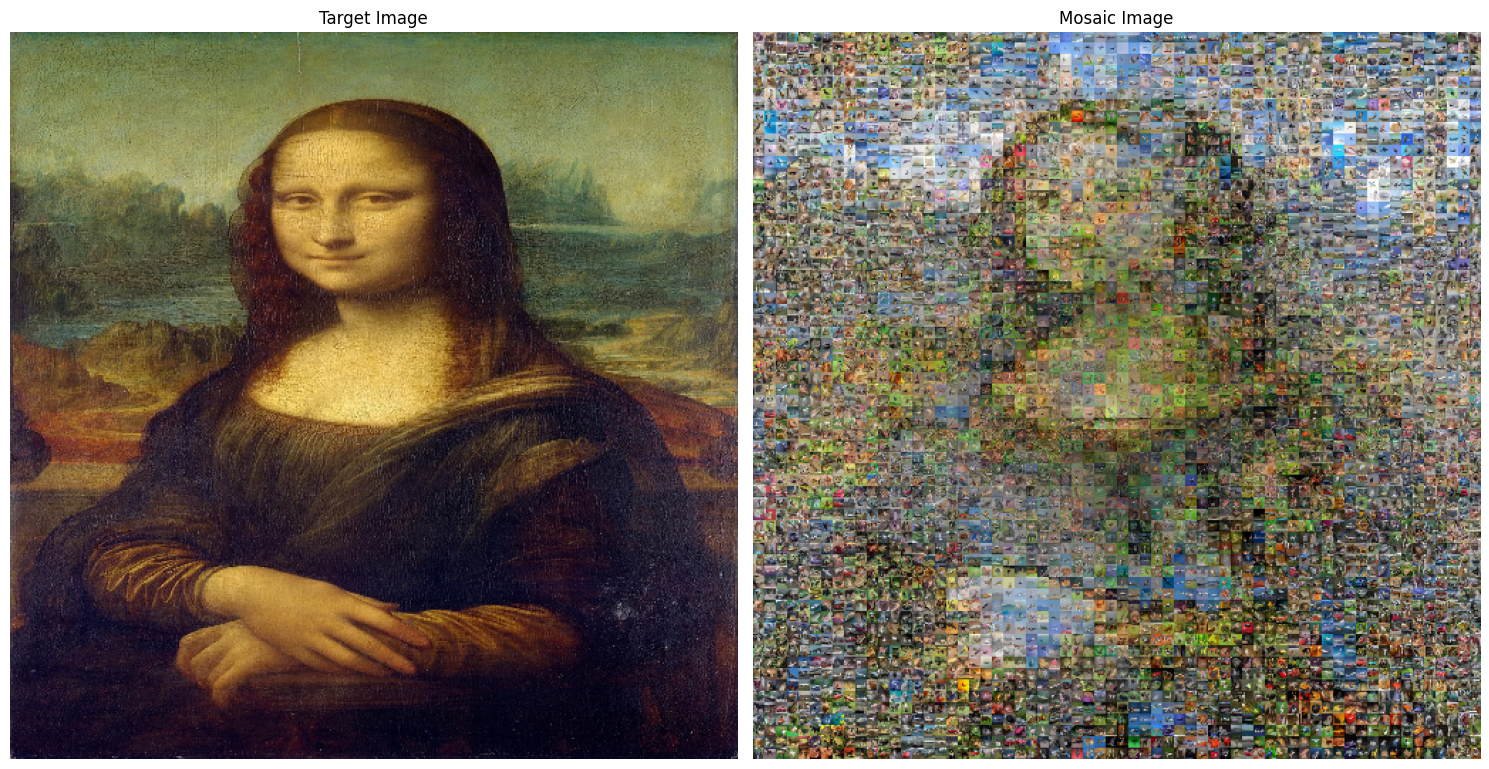

In [8]:
results = generator.run_unique_spatial_mosaic()

In [9]:
generator.save_results(results)

In [10]:
print(results)

{'assignment': [3006, 6989, 4353, 5989, 4206, 1006, 1310, 7431, 4264, 4845, 5409, 4950, 7221, 2962, 5102, 4510, 2589, 9647, 3079, 8901, 4730, 2581, 448, 8570, 5526, 6990, 630, 2643, 170, 872, 8873, 8329, 8421, 8820, 608, 2238, 8935, 874, 98, 8833, 8588, 376, 4734, 2897, 4535, 9018, 7276, 1647, 595, 4060, 8638, 549, 9515, 7085, 30, 722, 2124, 8647, 8468, 8253, 445, 4839, 3592, 1266, 5187, 7789, 7798, 8125, 9272, 7184, 3323, 3023, 2616, 5319, 5393, 6816, 7883, 1958, 861, 6850, 7922, 7665, 3752, 8945, 8538, 174, 913, 342, 8628, 7335, 537, 74, 496, 409, 356, 16, 2178, 557, 395, 2864, 3232, 7842, 8199, 6730, 2546, 2211, 4119, 109, 6004, 4187, 866, 1606, 2985, 4938, 247, 8017, 215, 157, 8182, 196, 8771, 1813, 8982, 429, 19, 5239, 2399, 2870, 2967, 5903, 7673, 1681, 671, 5212, 6215, 7889, 2027, 60, 5357, 6774, 5005, 7540, 8720, 6653, 4408, 5368, 5605, 5234, 8100, 974, 279, 791, 8320, 5070, 5947, 118, 340, 2911, 8057, 452, 2550, 970, 919, 93, 2764, 2720, 2776, 3943, 4805, 5250, 453, 9571, 3557